<a href="https://colab.research.google.com/github/Solo7602/MADPA/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-22-d05d3fb45a51>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Comment_processed'] = data['Comment'].apply(preprocess_text)
<ipython-input-22-d05d3fb45a51>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_Group'] = data['Age_Group'].apply(lambda x: 0 if x == '[0, 15]' else (1 if x == '[15, 40]' else 2))
/usr/local/lib/python3.11/dist-packages/sklearn/line

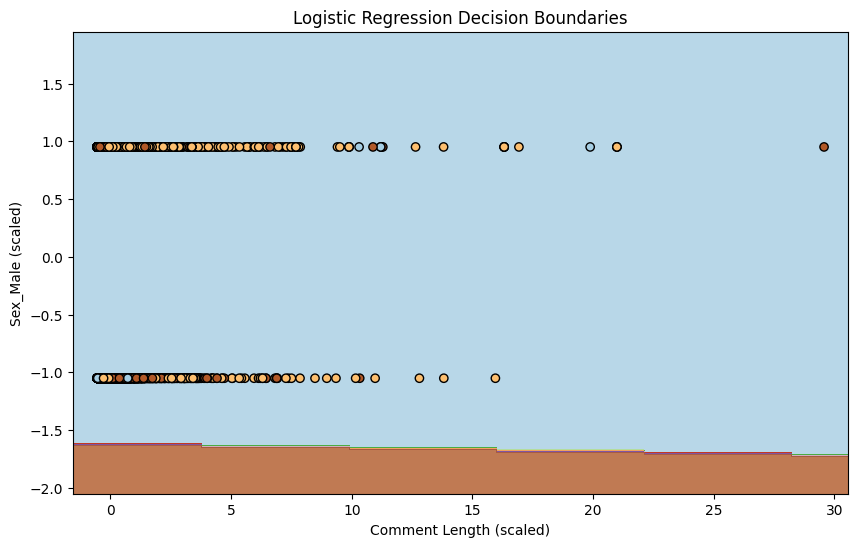

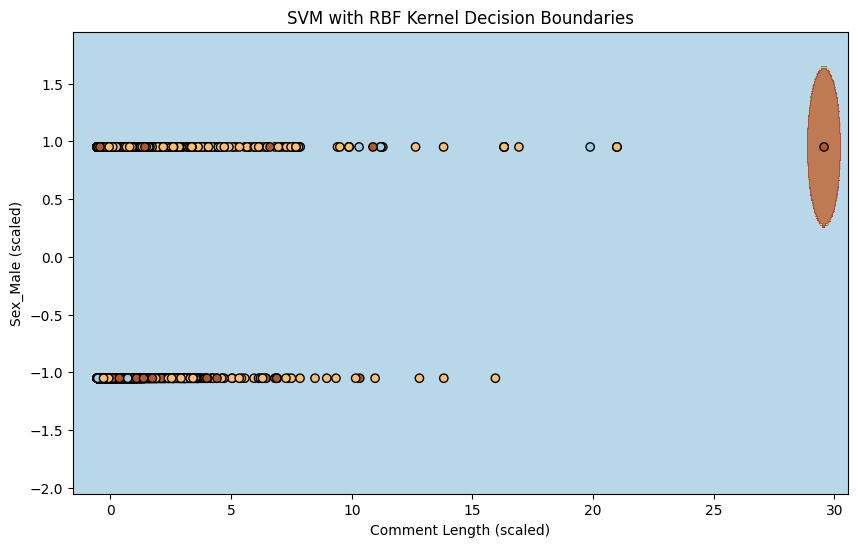

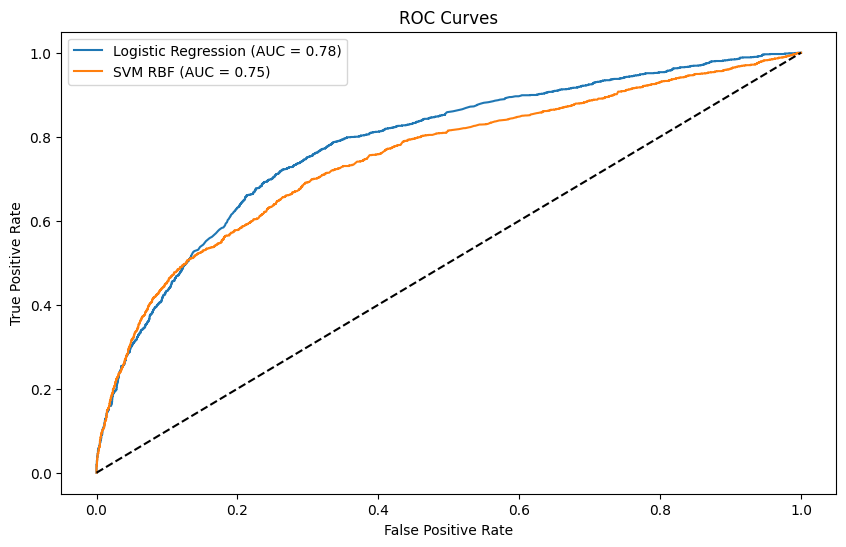


Сравнение моделей:
                 Model  Accuracy  F1-score
3             SVM Poly  0.716167  0.668150
4              SVM RBF  0.716000  0.671855
0  Logistic Regression  0.710333  0.676194
1           Linear SVM  0.702000  0.669075
2           Perceptron  0.673500  0.663818


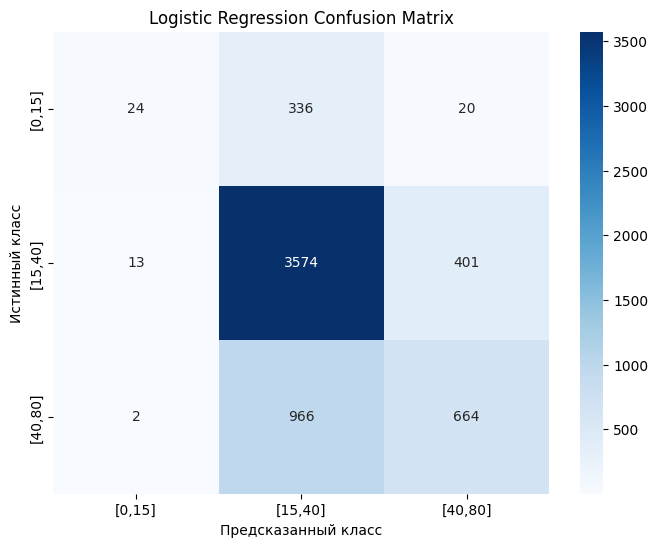

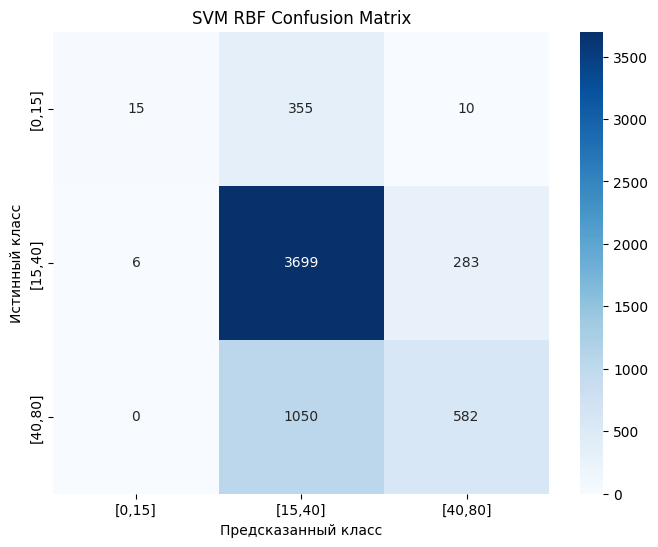

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from pymorphy3 import MorphAnalyzer
import re
import nltk
from razdel import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

nltk.download('stopwords')

# Загрузка данных
data_long = pd.read_csv('10k_dataset_processed_final_with_ageGroup.csv')

data = data_long.head(20000)

morph = MorphAnalyzer()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

russian_stopwords = stopwords.words('russian')


def preprocess_text(text):
    text = re.sub(patterns, ' ', text)
    text = str(text).lower()
    words = [token.text for token in tokenize(text)]
    words = [
        morph.parse(word)[0].normal_form
        for word in words
        if word not in russian_stopwords and len(word) > 2
    ]
    return ' '.join(words)

data['Comment_processed'] = data['Comment'].apply(preprocess_text)

# Векторизация
tfidf = TfidfVectorizer(max_features=1000)
text_features = tfidf.fit_transform(data['Comment_processed'])

# Масштабирование
scaler = StandardScaler()
numeric_features = data[['Comment_Length', 'Sex_Male']].values
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Подготовка данных
data['Age_Group'] = data['Age_Group'].apply(lambda x: 0 if x == '[0, 15]' else (1 if x == '[15, 40]' else 2))

X = hstack([numeric_features_scaled, text_features])
y = data['Age_Group']

# Разделение данных
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# 1. Логистическая регрессия
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# 2. Линейный SVM
linear_svm = LinearSVC(max_iter=10000)
linear_svm.fit(X_train_scaled, y_train)
y_pred_svm = linear_svm.predict(X_test_scaled)

# 3. Перцептрон
perceptron = Perceptron(max_iter=1000, tol=1e-3)
perceptron.fit(X_train_scaled, y_train)
y_pred_perc = perceptron.predict(X_test_scaled)

# 4. SVM с различными ядрами
# Полиномиальное ядро
param_grid_poly = {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'kernel': ['poly']}
svm_poly = GridSearchCV(SVC(), param_grid_poly, cv=5, scoring='accuracy')
svm_poly.fit(X_train_scaled, y_train)
y_pred_poly = svm_poly.predict(X_test_scaled)

# RBF ядро
param_grid_rbf = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto'], 'kernel': ['rbf']}
svm_rbf = GridSearchCV(SVC(), param_grid_rbf, cv=5, scoring='accuracy')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Визуализация границ решений
def plot_decision_boundary(model, X, y, title):
    # Берем только первые 2 числовых признака для визуализации
    X = X[:, :2].toarray() if hasattr(X, "toarray") else X[:, :2]

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Создаем фиктивные признаки для остальных 1000 измерений
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    dummy_features = np.zeros((mesh_points.shape[0], 1000))
    mesh_points = np.hstack([mesh_points, dummy_features])

    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Comment Length (scaled)')
    plt.ylabel('Sex_Male (scaled)')
    plt.title(title)
    plt.show()

plot_decision_boundary(log_reg, X_train_scaled, y_train, "Logistic Regression Decision Boundaries")
plot_decision_boundary(svm_rbf.best_estimator_, X_train_scaled, y_train, "SVM with RBF Kernel Decision Boundaries")

# ROC-кривые для бинарной классификации
y_binary = np.where(y == 2, 1, 0)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=42)

log_reg_bin = LogisticRegression(max_iter=1000)
log_reg_bin.fit(X_train_bin, y_train_bin)

svm_rbf_bin = SVC(kernel='rbf', probability=True)
svm_rbf_bin.fit(X_train_bin, y_train_bin)

plt.figure(figsize=(10, 6))
y_prob_log = log_reg_bin.predict_proba(X_test_bin)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test_bin, y_prob_log)
roc_auc_log = roc_auc_score(y_test_bin, y_prob_log)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')

y_prob_svm = svm_rbf_bin.predict_proba(X_test_bin)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_prob_svm)
roc_auc_svm = roc_auc_score(y_test_bin, y_prob_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM RBF (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Сравнение моделей
models = {
    'Logistic Regression': y_pred_log,
    'Linear SVM': y_pred_svm,
    'Perceptron': y_pred_perc,
    'SVM Poly': y_pred_poly,
    'SVM RBF': y_pred_rbf
}

results = []
for name, y_pred in models.items():
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results)
print("\nСравнение моделей:")
print(results_df.sort_values(by='Accuracy', ascending=False))

# Матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['[0,15]', '[15,40]', '[40,80]'],
                yticklabels=['[0,15]', '[15,40]', '[40,80]'])
    plt.title(title)
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rbf, "SVM RBF Confusion Matrix")